In [21]:
import NO_utils_multiple
import NO_utils
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torch
from datetime import datetime
from scipy.ndimage import rotate

## Load and visualize data

In [2]:
# Helper function to load and process a dataset
def load_and_process_dataset(data_path, print_dataset=True):
    start_time = time.time()
    (designs, design_params, n_designs, n_panes, design_res,
     WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors,
     EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x,
     EIGENVECTOR_DATA_y, const, N_struct,
     imag_tol, rng_seed_offset) = NO_utils.extract_data(data_path)

    print(f"Loading dataset path: {data_path}")

    # Convert all bands to spatial domain
    bands = np.arange(1, n_bands + 1)
    bands_fft = np.zeros((n_bands, design_res, design_res))
    for i, band in enumerate(bands):
        bands_fft[i], _ = NO_utils_multiple.const_to_spatial(band, design_res, plot_result=False, scaling_factor=1.0)

    # Create the result dictionary
    dataset = {
        "designs": designs, "design_params": design_params, "n_designs": n_designs,
        "WAVEVECTOR_DATA": WAVEVECTOR_DATA, "WAVEFORM_DATA": WAVEFORM_DATA,
        "EIGENVALUE_DATA": EIGENVALUE_DATA, "EIGENVECTOR_DATA_x": EIGENVECTOR_DATA_x,
        "EIGENVECTOR_DATA_y": EIGENVECTOR_DATA_y, "bands_fft": bands_fft
    }
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print dataset sizes and elapsed time
    if print_dataset:
        print(f"Dataset loaded from {data_path}:")
        for key, value in dataset.items():
            print(f"  {key}: {np.shape(value)}")
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    return dataset

def save_dataset(save_path, designs, design_params, waveforms, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft):
    """
    Save dataset arrays to a specified path.
    
    Parameters:
    - save_path: Path to save the dataset
    - designs: Array of design patterns
    - design_params: Array of design parameters
    - waveforms: Array of waveform data
    - eigenvalue_data: Array of eigenvalues
    - eigenvector_data_x: Array of x-component eigenvectors
    - eigenvector_data_y: Array of y-component eigenvectors
    - bands_fft: Array of band data in Fourier space
    """
    os.makedirs(save_path, exist_ok=True)
    
    # Save each array with np.save
    np.save(os.path.join(save_path, 'designs.npy'), designs)
    np.save(os.path.join(save_path, 'design_params.npy'), design_params)
    np.save(os.path.join(save_path, 'waveforms.npy'), waveforms)
    np.save(os.path.join(save_path, 'eigenvalue_data.npy'), eigenvalue_data)
    np.save(os.path.join(save_path, 'eigenvector_data_x.npy'), eigenvector_data_x)
    np.save(os.path.join(save_path, 'eigenvector_data_y.npy'), eigenvector_data_y)
    np.save(os.path.join(save_path, 'bands_fft.npy'), bands_fft)
    
    print(f"Dataset saved to {save_path}")

In [3]:
# Load data directly from numpy files
data_path = "data/extracted_combined_data_first_band"

# Load each array directly
designs = np.load(os.path.join(data_path, "designs.npy"))
design_params = np.load(os.path.join(data_path, "design_params.npy"))
waveforms = np.load(os.path.join(data_path, "waveforms.npy"))
eigenvalue_data = np.load(os.path.join(data_path, "eigenvalue_data.npy"))
eigenvector_data_x = np.load(os.path.join(data_path, "eigenvector_data_x.npy"))
eigenvector_data_y = np.load(os.path.join(data_path, "eigenvector_data_y.npy"))
bands_fft = np.load(os.path.join(data_path, "bands_fft.npy"))

# Print shapes of loaded arrays
print(f'shape of designs: {np.shape(designs)}')
print(f'shape of waveforms: {np.shape(waveforms)}')
print(f'shape of EIGENVALUE_DATA: {np.shape(eigenvalue_data)}')
print(f'shape of EIGENVECTOR_DATA_x: {np.shape(eigenvector_data_x)}')
print(f'shape of EIGENVECTOR_DATA_y: {np.shape(eigenvector_data_y)}')
print(f'shape of band_fft: {np.shape(bands_fft)}')

shape of designs: (1800, 32, 32)
shape of waveforms: (325, 32, 32)
shape of EIGENVALUE_DATA: (1800, 325)
shape of EIGENVECTOR_DATA_x: (1800, 325, 32, 32)
shape of EIGENVECTOR_DATA_y: (1800, 325, 32, 32)
shape of band_fft: (32, 32)


In [6]:
n_designs = np.shape(designs)[0]
n_bands = np.shape(bands_fft)[0]
n_waveforms = np.shape(waveforms)[0]
print(f'number of designs: {n_designs}')
print(f'number of bands: {n_bands}')
print(f'number of waveforms: {n_waveforms}')

# Print the max and min values of all the arrays with a size of 400 in its first dimension.
print(f'Max value of designs: {np.max(designs)}')
print(f'Min value of designs: {np.min(designs)}')
print(f'Max value of WAVEFORM_DATA: {np.max(waveforms)}')
print(f'Min value of WAVEFORM_DATA: {np.min(waveforms)}')
print(f'Max value of WAVEVECTOR_DATA_x: {np.max(eigenvector_data_x)}')
print(f'Min value of WAVEVECTOR_DATA_x: {np.min(eigenvector_data_x)}')
print(f'Max value of WAVEVECTOR_DATA_y: {np.max(eigenvector_data_y)}')
print(f'Min value of WAVEVECTOR_DATA_y: {np.min(eigenvector_data_y)}')

# Duplicate waveforms n_designs times to make it the shape (n_designs, n_waveforms, 32, 32) from (n_waveforms, 32, 32)
waveforms_expanded = np.expand_dims(waveforms, axis=0)
print(f'waveforms_expanded shape: {np.shape(waveforms_expanded)}')
repeated_waveforms = np.repeat(waveforms_expanded, n_designs, axis=0)
designs_expanded = np.expand_dims(designs, axis=1)
print(f'designs_expanded shape: {np.shape(designs_expanded)}')
repeated_designs = np.repeat(designs_expanded, n_waveforms, axis=1)

print(f'shape of repeated_waveforms: {np.shape(repeated_waveforms)}')
print(f'shape of repeated_designs: {np.shape(repeated_designs)}')

number of designs: 1800
number of bands: 32
number of waveforms: 325
Max value of designs: 1.0
Min value of designs: 0.0
Max value of WAVEFORM_DATA: 1.0
Min value of WAVEFORM_DATA: -0.9999995318233016
Max value of WAVEVECTOR_DATA_x: (0.32568359375+0j)
Min value of WAVEVECTOR_DATA_x: (-0.310791015625+0.03521728515625j)
Max value of WAVEVECTOR_DATA_y: (0.314208984375+0j)
Min value of WAVEVECTOR_DATA_y: (-0.322265625-0.047760009765625j)
waveforms_expanded shape: (1, 325, 32, 32)
designs_expanded shape: (1800, 1, 32, 32)
shape of repeated_waveforms: (1800, 325, 32, 32)
shape of repeated_designs: (1800, 325, 32, 32)


In [7]:
# Flatten the arrays and plot a separate histogram showing the distribution of values for each array with a size of 400 in its first dimension. Drop any imaginary components for the eigenvectors.
designs_flat = designs.flatten()
WAVEFORM_DATA_flat = waveforms.flatten()
EIGENVECTOR_DATA_x_flat = eigenvector_data_x.flatten()
EIGENVECTOR_DATA_y_flat = eigenvector_data_y.flatten()

# Take the symlog of the flattened arrays. Take the real value for complex valued arrays.
# designs_flat_symlog = np.sign(designs_flat) * np.log10(np.abs(designs_flat) + 1)
# WAVEFORM_DATA_flat_symlog = np.sign(WAVEFORM_DATA_flat) * np.log10(np.abs(WAVEFORM_DATA_flat) + 1)
# EIGENVECTOR_DATA_x_flat_symlog = np.sign(EIGENVECTOR_DATA_x_flat.real) * np.log10(np.abs(EIGENVECTOR_DATA_x_flat.real) + 1)
# EIGENVECTOR_DATA_y_flat_symlog = np.sign(EIGENVECTOR_DATA_y_flat.real) * np.log10(np.abs(EIGENVECTOR_DATA_y_flat.real) + 1)

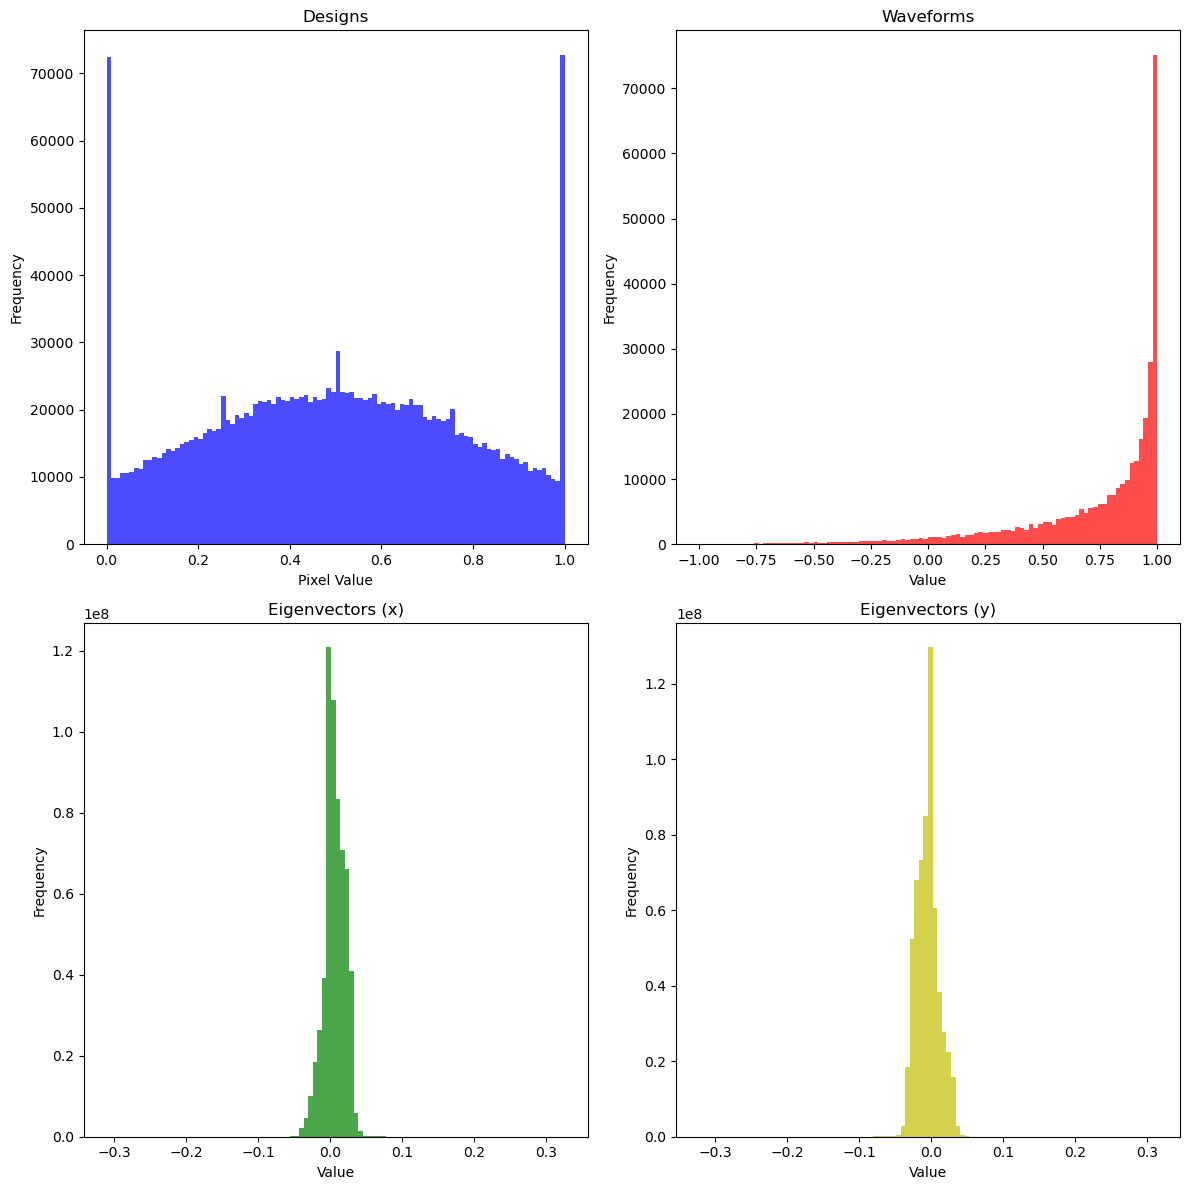

In [8]:
# Plot the histograms of flattened real values for each array
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].hist(designs.flatten(), bins=100, color='b', alpha=0.7)
axes[0, 0].set_title('Designs')
axes[0, 0].set_xlabel('Pixel Value')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(waveforms.flatten(), bins=100, color='r', alpha=0.7)
axes[0, 1].set_title('Waveforms')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(eigenvector_data_x.flatten().real, bins=100, color='g', alpha=0.7)
axes[1, 0].set_title('Eigenvectors (x)')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(eigenvector_data_y.flatten().real, bins=100, color='y', alpha=0.7)
axes[1, 1].set_title('Eigenvectors (y)')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
def augment_images(images, flip_x=False, flip_y=False, rotation_angle=0):
    """
    Augment images with flips and rotation.
    
    Parameters:
    - images: Array of images with shape (N, C, H, W) or (N, H, W)
    - flip_x: Boolean to flip horizontally
    - flip_y: Boolean to flip vertically  
    - rotation_angle: Angle in degrees to rotate (0-360)
    
    Returns:
    - Augmented images array
    """
    # Make a copy to avoid modifying original
    augmented = images.copy()
    
    # Handle different array shapes
    if len(augmented.shape) == 4:
        # Shape is (N, C, H, W)
        if flip_x:
            augmented = augmented[:, :, :, ::-1]
        if flip_y:
            augmented = augmented[:, :, ::-1, :]
        if rotation_angle != 0:
            # Rotate each channel separately
            for n in range(augmented.shape[0]):
                for c in range(augmented.shape[1]):
                    augmented[n,c] = np.rot90(augmented[n,c],
                                            k=int(rotation_angle/90))
    else:
        # Shape is (N, H, W)
        if flip_x:
            augmented = augmented[:, :, ::-1]
        if flip_y:
            augmented = augmented[:, ::-1, :]
        if rotation_angle != 0:
            # Rotate each image
            for n in range(augmented.shape[0]):
                augmented[n] = np.rot90(augmented[n],
                                      k=int(rotation_angle/90))
                
    return augmented

def create_augmented_dataset(designs, waveforms, eigenvector_data_x, eigenvector_data_y,
                           flip_x=False, flip_y=False, rotation_angle=0):
    """
    Create an augmented version of the dataset, only augmenting spatial data.
    
    Parameters:
    - Original dataset arrays
    - flip_x: Boolean to flip horizontally
    - flip_y: Boolean to flip vertically
    - rotation_angle: Angle in degrees to rotate (0-360)
    
    Returns:
    - Tuple of arrays where only spatial data is augmented
    """
    # Only augment the spatial/image data
    aug_designs = augment_images(designs, flip_x, flip_y, rotation_angle)
    aug_waveforms = augment_images(waveforms, flip_x, flip_y, rotation_angle)
    aug_eigenvector_x = augment_images(eigenvector_data_x, flip_x, flip_y, rotation_angle)
    aug_eigenvector_y = augment_images(eigenvector_data_y, flip_x, flip_y, rotation_angle)
    
    # Return tuple with augmented spatial data and original non-spatial data
    return (aug_designs, 
            aug_waveforms,
            aug_eigenvector_x,
            aug_eigenvector_y)

In [11]:
# Print shapes of loaded arrays
print(f'shape of designs: {np.shape(designs)}')
print(f'shape of waveforms: {np.shape(waveforms)}')
print(f'shape of EIGENVALUE_DATA: {np.shape(eigenvalue_data)}')
print(f'shape of EIGENVECTOR_DATA_x: {np.shape(eigenvector_data_x)}')
print(f'shape of EIGENVECTOR_DATA_y: {np.shape(eigenvector_data_y)}')
print(f'shape of band_fft: {np.shape(bands_fft)}')

shape of designs: (1800, 32, 32)
shape of waveforms: (325, 32, 32)
shape of EIGENVALUE_DATA: (1800, 325)
shape of EIGENVECTOR_DATA_x: (1800, 325, 32, 32)
shape of EIGENVECTOR_DATA_y: (1800, 325, 32, 32)
shape of band_fft: (32, 32)


In [29]:
def rotate_2d_image(image, angle):
    """
    Rotate a 2D image (grayscale) by a specified angle.

    Parameters:
    image (numpy.ndarray): The 2D grayscale image to rotate.
    angle (float): Rotation angle in degrees (counterclockwise).

    Returns:
    numpy.ndarray: The rotated image.
    """
    # Ensure the input is a 2D image
    if len(image.shape) != 2:
        raise ValueError("Input image must be 2D (grayscale).")
    H, W = image.shape

    # Convert angle to radians
    theta = np.radians(angle)

    # Compute rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Create meshgrid of (x, y) coordinates
    y, x = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    coords = np.stack([x.flatten(), y.flatten()], axis=1)

    # Translate coordinates to the center of the image
    center = np.array([W // 2, H // 2])
    centered_coords = coords - center

    # Rotate coordinates
    rotated_coords = rotation_matrix @ centered_coords.T
    rotated_coords = rotated_coords.T

    # Translate coordinates back to the original position
    final_coords = np.round(rotated_coords + center).astype(int)

    # Ensure coordinates are within bounds
    final_coords = np.clip(final_coords, [0, 0], [W - 1, H - 1])

    # Create rotated image by sampling the original image at the new coordinates
    rotated_image = image[final_coords[:, 1], final_coords[:, 0]]  # y, x indexing
    rotated_image = rotated_image.reshape(H, W)  # Reshape back to (H, W)

    return rotated_image


Image shape: (32, 32)


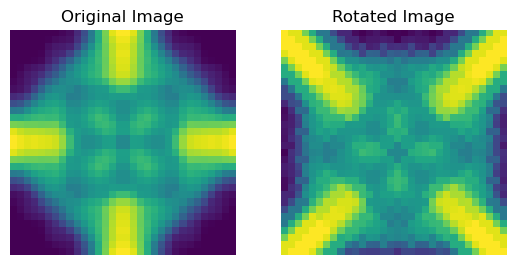

In [35]:
# Test case
image = designs[0]  # Load single test image
print(f'Image shape: {image.shape}')
rotated = rotate_2d_image(image, angle=135)  # Rotate by 45 degrees

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image)  # Directly use the NumPy image
plt.title("Original Image")
plt.axis("off")

# Plot the rotated image
plt.subplot(1, 2, 2)
plt.imshow(rotated)  # Directly use the rotated NumPy image
plt.title("Rotated Image")
plt.axis("off")

plt.show()

In [75]:
def rotate_2d_stack(images, angle):
    """
    Rotate a stack of 2D grayscale images assuming infinite tiling of the original image.

    Parameters:
    images (numpy.ndarray): Stack of 2D grayscale images to rotate.
                            Shape: (N, H, W), where:
                            * N = Number of images
                            * H = Height of each image
                            * W = Width of each image
    angle (float): Rotation angle in degrees (counterclockwise).

    Returns:
    numpy.ndarray: Rotated stack of images with the same shape as the input.
    """
    # Ensure the input is a stack of 2D grayscale images
    if len(images.shape) != 3:
        raise ValueError("Input must be a stack of 2D grayscale images (shape: N, H, W).")

    N, H, W = images.shape  # Number of images, height, and width

    # Convert angle to radians
    theta = np.radians(angle)

    # Compute rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Create meshgrid of (x, y) coordinates for a single image
    y, x = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    coords = np.stack([x.flatten(), y.flatten()], axis=1)  # Shape: (H * W, 2)

    # Calculate the geometric center of the image (account for even-sized images)
    center = np.array([(W - 1) / 2, (H - 1) / 2])  # Precise geometric center
    centered_coords = coords - center  # Translate the grid to the image center

    # Rotate coordinates
    rotated_coords = rotation_matrix @ centered_coords.T  # Shape: (2, H * W)
    rotated_coords = rotated_coords.T  # Shape: (H * W, 2)

    # Translate coordinates back to the original image position
    final_coords = np.round(rotated_coords + center).astype(int)  # Shape: (H * W, 2)

    # Use modular arithmetic to wrap coordinates around the image bounds
    wrapped_coords = final_coords % np.array([W, H])  # Wrap the x and y coordinates (mod W and mod H)

    # Create rotated images by sampling the original images at wrapped coordinates
    rotated_images = np.zeros_like(images)
    for n in range(N):  # Iterate through the image stack
        rotated_images[n] = images[n, wrapped_coords[:, 1], wrapped_coords[:, 0]].reshape(H, W)

    return rotated_images

def plot_image_tiling(image):
    """
    Plots a 3x3 tiling of the given image.

    Parameters:
    - image: 2D array representing a single image
    """
    tiled_image = np.tile(image, (3, 3))
    plt.imshow(tiled_image, cmap='gray')
    plt.axis("off")
    plt.title("3x3 Image Tiling")
    plt.show()

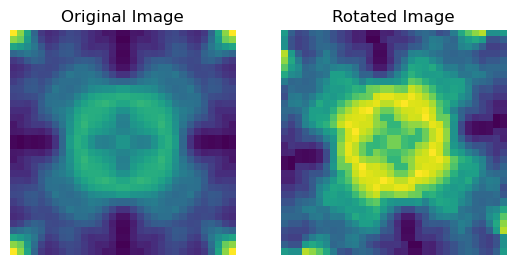

In [76]:
designs_rot_15 = rotate_2d_stack(designs, angle=10)

# Plot a sample from designs and the same index from designs_rot_15 to check functionality.
# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(designs[120])  # Directly use the NumPy image
plt.title("Original Image")
plt.axis("off")

# Plot the rotated image
plt.subplot(1, 2, 2)
plt.imshow(designs_rot_15[120])  # Directly use the rotated NumPy image
plt.title("Rotated Image")
plt.axis("off")

plt.show()


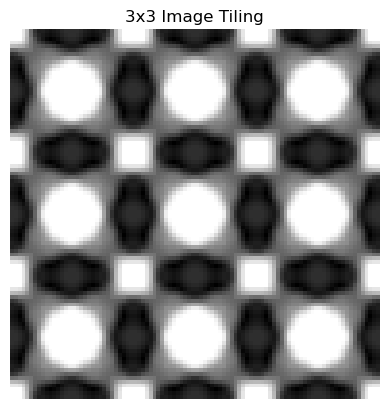

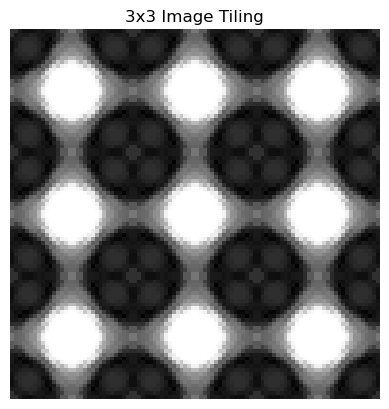

In [66]:
plot_image_tiling(designs[122])
plot_image_tiling(designs_rot_15[122])

TypeError: Invalid shape (32,) for image data

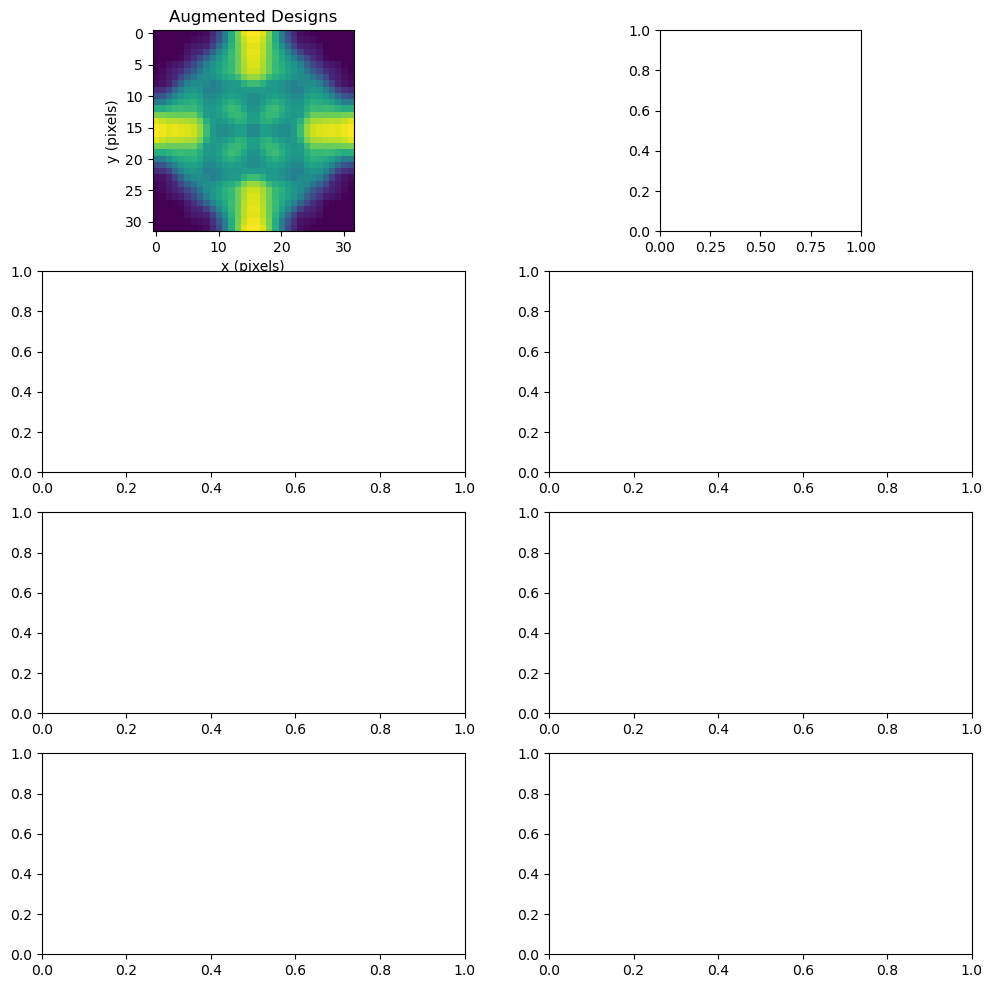

In [13]:
# Test a sample set of images with create_augmented_dataset
aug_designs, aug_waveforms, aug_eigenvector_x, aug_eigenvector_y = create_augmented_dataset(repeated_designs, repeated_waveforms, eigenvector_data_x, eigenvector_data_y, flip_x=False, flip_y=False, rotation_angle=45)

# Plot the augmented images next to the original images in a grid of 4x2 (only plot designs, waveforms, eigenvectors x & y)
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

axes[0, 0].imshow(aug_designs[0, 0], cmap='viridis')
axes[0, 0].set_title('Augmented Designs')
axes[0, 0].set_xlabel('x (pixels)')
axes[0, 0].set_ylabel('y (pixels)')

axes[0, 1].imshow(designs[0, 0], cmap='viridis')
axes[0, 1].set_title('Original Designs')
axes[0, 1].set_xlabel('x (pixels)')
axes[0, 1].set_ylabel('y (pixels)')

axes[1, 0].imshow(aug_waveforms[0, 0], cmap='viridis')
axes[1, 0].set_title('Augmented Waveforms')
axes[1, 0].set_xlabel('x (m)')
axes[1, 0].set_ylabel('y (m)')

axes[1, 1].imshow(waveforms[0, 0], cmap='viridis')
axes[1, 1].set_title('Original Waveforms')
axes[1, 1].set_xlabel('x (m)')
axes[1, 1].set_ylabel('y (m)')

axes[2, 0].imshow(aug_eigenvector_x[0, 0], cmap='viridis')
axes[2, 0].set_title('Augmented Eigenvectors (x)')
axes[2, 0].set_xlabel('x (pixels)')
axes[2, 0].set_ylabel('y (pixels)')

axes[2, 1].imshow(eigenvector_data_x[0, 0], cmap='viridis')
axes[2, 1].set_title('Original Eigenvectors (x)')
axes[2, 1].set_xlabel('x (pixels)')
axes[2, 1].set_ylabel('y (pixels)')

axes[3, 0].imshow(aug_eigenvector_y[0, 0], cmap='viridis')
axes[3, 0].set_title('Augmented Eigenvectors (y)')
axes[3, 0].set_xlabel('x (pixels)')
axes[3, 0].set_ylabel('y (pixels)')

axes[3, 1].imshow(eigenvector_data_y[0, 0], cmap='viridis')
axes[3, 1].set_title('Original Eigenvectors (y)')
axes[3, 1].set_xlabel('x (pixels)')
axes[3, 1].set_ylabel('y (pixels)')

plt.tight_layout()
plt.show()

In [ ]:
def augment_images(images, flip_x=False, flip_y=False, rotation_angle=0):
    """
    Augment images with flips and rotation.

    Parameters:
    - images: Array of images with shape (N, C, H, W) or (N, H, W)
    - flip_x: Boolean to flip horizontally
    - flip_y: Boolean to flip vertically
    - rotation_angle: Angle in degrees to rotate (0-360)

    Returns:
    - Augmented images array
    """
    # Make a copy to avoid modifying original
    augmented = images.copy()

    # Handle different array shapes
    if len(augmented.shape) == 4:
        # Shape is (N, C, H, W)
        if flip_x:
            augmented = augmented[:, :, :, ::-1]
        if flip_y:
            augmented = augmented[:, :, ::-1, :]
        if rotation_angle != 0:
            # Rotate each channel separately
            for n in range(augmented.shape[0]):
                for c in range(augmented.shape[1]):
                    augmented[n,c] = np.rot90(augmented[n,c],
                                              k=int(rotation_angle/90))
    else:
        # Shape is (N, H, W)
        if flip_x:
            augmented = augmented[:, :, ::-1]
        if flip_y:
            augmented = augmented[:, ::-1, :]
        if rotation_angle != 0:
            # Rotate each image
            for n in range(augmented.shape[0]):
                augmented[n] = np.rot90(augmented[n],
                                        k=int(rotation_angle/90))

    return augmented

def create_augmented_dataset(designs, design_params, waveforms, eigenvalue_data,
                             eigenvector_data_x, eigenvector_data_y, bands_fft,
                             flip_x=False, flip_y=False, rotation_angle=0):
    """
    Create an augmented version of the dataset, only augmenting spatial data.

    Parameters:
    - Original dataset arrays
    - flip_x: Boolean to flip horizontally
    - flip_y: Boolean to flip vertically
    - rotation_angle: Angle in degrees to rotate (0-360)

    Returns:
    - Tuple of arrays where only spatial data is augmented
    """
    # Only augment the spatial/image data
    aug_designs = augment_images(designs, flip_x, flip_y, rotation_angle)
    aug_waveforms = augment_images(waveforms, flip_x, flip_y, rotation_angle)
    aug_eigenvector_x = augment_images(eigenvector_data_x, flip_x, flip_y, rotation_angle)
    aug_eigenvector_y = augment_images(eigenvector_data_y, flip_x, flip_y, rotation_angle)

    # Return tuple with augmented spatial data and original non-spatial data
    return (aug_designs,
            design_params,  # original unchanged
            aug_waveforms,
            eigenvalue_data,  # original unchanged
            aug_eigenvector_x,
            aug_eigenvector_y,
            bands_fft)  # original unchanged


In [7]:
# Draw a random design and its corresponding eigenvectors
#n_bands = 6
random_seed = 36
random.seed(random_seed)
sample_index = np.random.randint(0, n_designs)
sample_geometry = designs[sample_index, 0]
sample_band = np.random.randint(0, n_bands)
sample_waveform_index = np.random.randint(0, n_waveforms)
sample_waveform = waveforms[sample_waveform_index]
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_waveform_index}')

Design: 761, Band: 0, Wavevector: 51


designs shape: (1200, 3, 32, 32)
WAVEFORM_DATA shape: (325, 32, 32)
Average pixel values of all geometries: 0.49950732668277104
Average pixel values of all waveforms: 0.6164027212723144


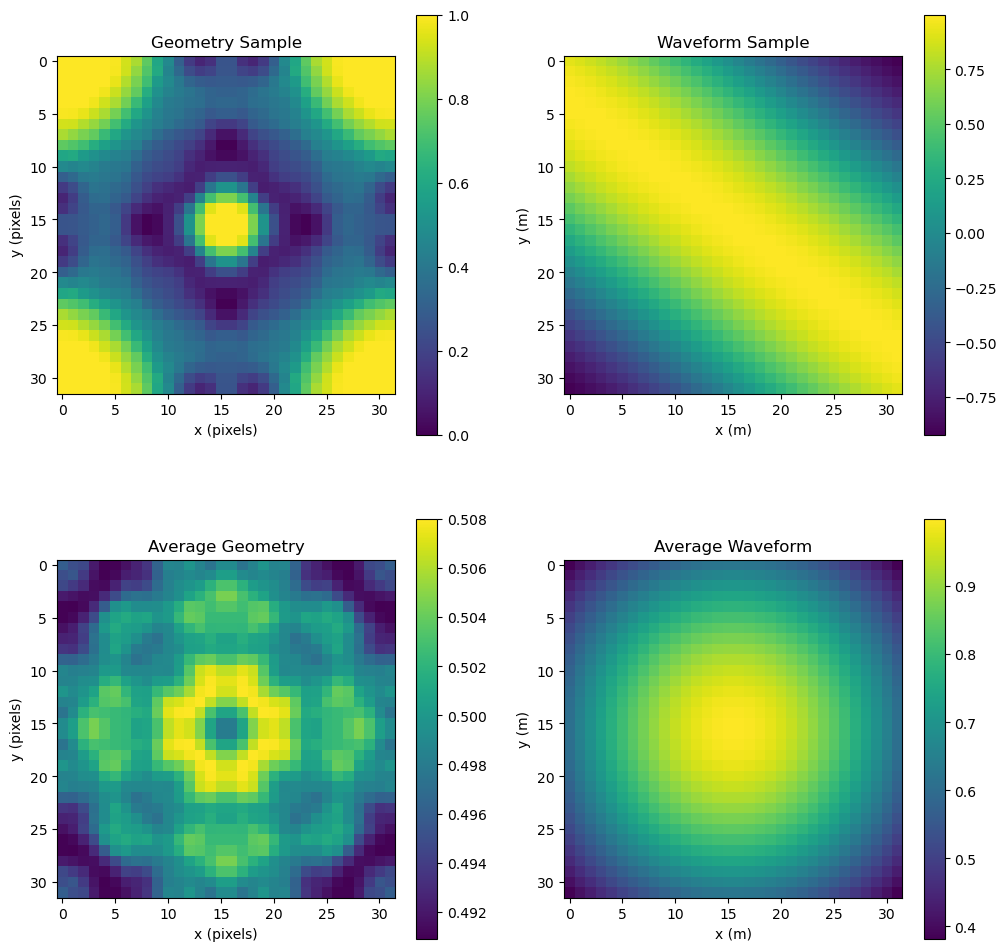

In [8]:
# Calculate the average values for geometry and waveform across all samples
print(f'designs shape: {designs.shape}')
print(f'WAVEFORM_DATA shape: {waveforms.shape}')

avg_geometry = np.mean(designs[:, 0], axis=0)
avg_waveform = np.mean(waveforms[:], axis=0)

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the geometry sample on the top-left
im1 = axes[0, 0].imshow(sample_geometry, cmap='viridis')
axes[0, 0].set_title('Geometry Sample')
axes[0, 0].set_xlabel('x (pixels)')
axes[0, 0].set_ylabel('y (pixels)')
plt.colorbar(im1, ax=axes[0, 0])

# Plot the waveform sample on the top-right
im2 = axes[0, 1].imshow(sample_waveform, cmap='viridis')
axes[0, 1].set_title('Waveform Sample')
axes[0, 1].set_xlabel('x (m)')
axes[0, 1].set_ylabel('y (m)')
plt.colorbar(im2, ax=axes[0, 1])

# Plot the average geometry on the bottom-left
im3 = axes[1, 0].imshow(avg_geometry, cmap='viridis')
axes[1, 0].set_title('Average Geometry')
axes[1, 0].set_xlabel('x (pixels)')
axes[1, 0].set_ylabel('y (pixels)')
plt.colorbar(im3, ax=axes[1, 0])

# Plot the average waveform on the bottom-right
im4 = axes[1, 1].imshow(avg_waveform, cmap='viridis')
axes[1, 1].set_title('Average Waveform')
axes[1, 1].set_xlabel('x (m)')
axes[1, 1].set_ylabel('y (m)')
plt.colorbar(im4, ax=axes[1, 1])

print(f'Average pixel values of all geometries: {np.mean(designs[:,0])}')
print(f'Average pixel values of all waveforms: {np.mean(waveforms[0,:])}')

Design: 761, Band: 0, Wavevector: 51


C:\Users\hz283\Documents\Duke\Research\NO-2D-Metamaterials\NO_utils.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


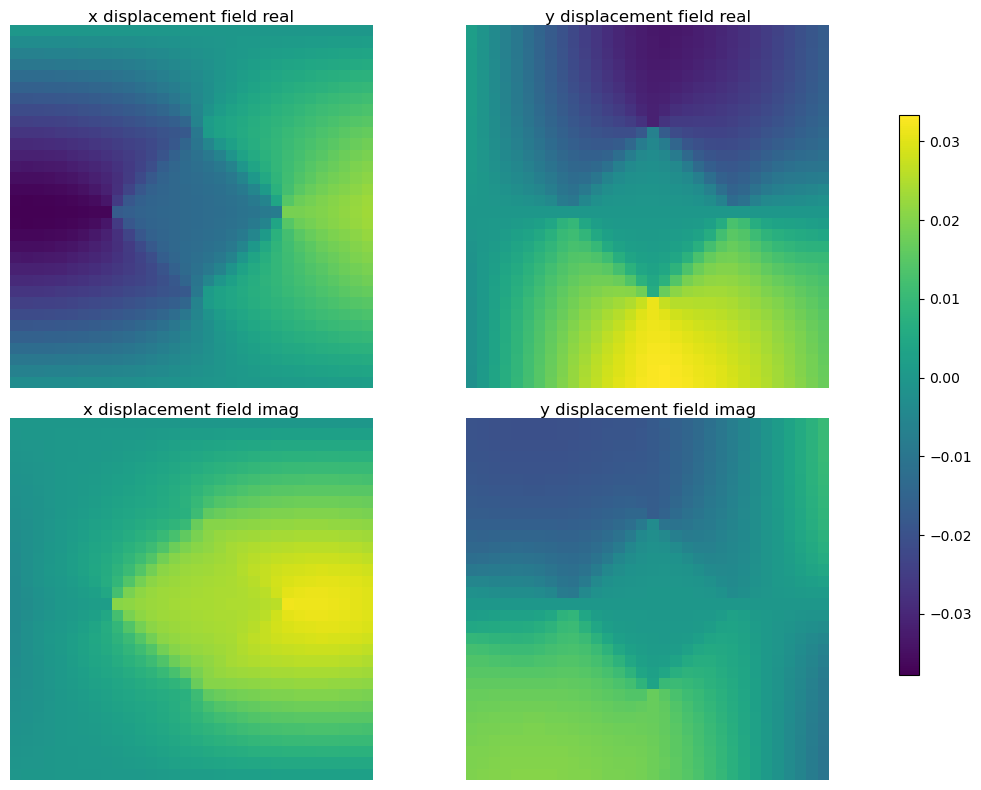

In [9]:
# View eigenvectors for the selected design, band, and wavevector
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_waveform_index}')
sample_eigenvector_x = eigenvector_data_x[sample_index, sample_waveform_index, sample_band]
sample_eigenvector_y = eigenvector_data_y[sample_index, sample_waveform_index, sample_band]

NO_utils.plot_eigenvectors(sample_eigenvector_x, sample_eigenvector_y, unify_scales=True)

## Model architecture & training

In [51]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Import specialized neural operator model tools
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer
from neuralop.training import CheckpointCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.datasets import data_transforms
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, ConcatDataset
from sklearn.preprocessing import StandardScaler

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# Optional: If you are working with graph data or architectures
# import torch_geometric

# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function

In [11]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.4.1+cu118


In [12]:
# Print the shape of the first input tensor for confirmation
print("Shape of the first input tensor to be assigned:")
print("designs[0, 0]:", designs[0, 0].shape)
print("WAVEFORM_DATA[0, 0]:", waveforms[0, 0].shape)

# Print the shape of the first output tensor for confirmation
print("Shape of the first output tensor to be assigned:")
print("EIGENVECTOR_DATA_x[0, 0, 0]:", eigenvector_data_x[0, 0, 0].shape)
print("EIGENVECTOR_DATA_x[0, 0, 0]:", eigenvector_data_y[0, 0, 0].shape)

Shape of the first input tensor to be assigned:
designs[0, 0]: (32, 32)
WAVEFORM_DATA[0, 0]: (32,)
Shape of the first output tensor to be assigned:
EIGENVECTOR_DATA_x[0, 0, 0]: (32, 32)
EIGENVECTOR_DATA_x[0, 0, 0]: (32, 32)


In [13]:
def symlog_transform(x, linthresh=1):
    return np.sign(x) * np.log10(np.abs(x) + linthresh)

def symlog_inverse_transform(y, linthresh=1):
    return np.sign(y) * (10**np.abs(y) - linthresh)

# Function to fit and transform with StandardScaler, with optional symlog transformation
def standardize_array(array, symlog=False):
    scaler = StandardScaler()
    original_shape = array.shape
    array_flat = array.reshape(-1, 1)  # Flatten the array to 2D

    if symlog:
        array_flat = symlog_transform(array_flat)

    array_standardized = scaler.fit_transform(array_flat).reshape(original_shape)
    mean = scaler.mean_[0]
    scale = scaler.scale_[0]

    return array_standardized, mean, scale, symlog

In [14]:
# Standardizing EIGENVALUE_DATA and casting to float16
EIGENVALUE_DATA_standardized, eigenvalue_mean, eigenvalue_scale, _ = standardize_array(eigenvalue_data)
EIGENVALUE_DATA_standardized = EIGENVALUE_DATA_standardized.astype(np.float16)

# Standardizing EIGENVECTOR_DATA_x (real and imaginary parts separately) and casting to float16
EIGENVECTOR_x_r = eigenvector_data_x.real.astype(np.float16)
EIGENVECTOR_x_i = eigenvector_data_x.imag.astype(np.float16)

EIGENVECTOR_x_r_standardized, eigvector_x_r_mean, eigvector_x_r_scale, _ = standardize_array(EIGENVECTOR_x_r)
EIGENVECTOR_x_r_standardized = EIGENVECTOR_x_r_standardized.astype(np.float16)

EIGENVECTOR_x_i_standardized, eigvector_x_i_mean, eigvector_x_i_scale, _ = standardize_array(EIGENVECTOR_x_i)
EIGENVECTOR_x_i_standardized = EIGENVECTOR_x_i_standardized.astype(np.float16)

# Standardizing EIGENVECTOR_DATA_y (real and imaginary parts separately) and casting to float16
EIGENVECTOR_y_r = eigenvector_data_y.real.astype(np.float16)
EIGENVECTOR_y_i = eigenvector_data_y.imag.astype(np.float16)

EIGENVECTOR_y_r_standardized, eigvector_y_r_mean, eigvector_y_r_scale, _ = standardize_array(EIGENVECTOR_y_r)
EIGENVECTOR_y_r_standardized = EIGENVECTOR_y_r_standardized.astype(np.float16)

EIGENVECTOR_y_i_standardized, eigvector_y_i_mean, eigvector_y_i_scale, _ = standardize_array(EIGENVECTOR_y_i)
EIGENVECTOR_y_i_standardized = EIGENVECTOR_y_i_standardized.astype(np.float16)

# Standardizing WAVEVECTOR_DATA and casting to float16
WAVEVECTOR_DATA_standardized, wavevector_mean, wavevector_scale, _ = standardize_array(waveforms)
WAVEVECTOR_DATA_standardized = WAVEVECTOR_DATA_standardized.astype(np.float16)

del eigenvector_data_x, eigenvector_data_y


In [15]:
# Print shapes and data types of arrays to verify
print("EIGENVALUE_DATA_standardized shape:", EIGENVALUE_DATA_standardized.shape, "dtype:", EIGENVALUE_DATA_standardized.dtype)
print("EIGENVECTOR_x_r_standardized shape:", EIGENVECTOR_x_r_standardized.shape, "dtype:", EIGENVECTOR_x_r_standardized.dtype)
print("EIGENVECTOR_x_i_standardized shape:", EIGENVECTOR_x_i_standardized.shape, "dtype:", EIGENVECTOR_x_i_standardized.dtype)
print("EIGENVECTOR_y_r_standardized shape:", EIGENVECTOR_y_r_standardized.shape, "dtype:", EIGENVECTOR_y_r_standardized.dtype)
print("EIGENVECTOR_y_i_standardized shape:", EIGENVECTOR_y_i_standardized.shape, "dtype:", EIGENVECTOR_y_i_standardized.dtype)
print("WAVEVECTOR_DATA_standardized shape:", WAVEVECTOR_DATA_standardized.shape, "dtype:", WAVEVECTOR_DATA_standardized.dtype)
print('\n')

# Print the mean and scale values for each standardized array
print("Eigenvalue mean, scale:", eigenvalue_mean, eigenvalue_scale)
print("Eigenvector x real mean, scale:", eigvector_x_r_mean, eigvector_x_r_scale)
print("Eigenvector x imag mean, scale:", eigvector_x_i_mean, eigvector_x_i_scale)
print("Eigenvector y real mean, scale:", eigvector_y_r_mean, eigvector_y_r_scale)
print("Eigenvector y imag mean, scale:", eigvector_y_i_mean, eigvector_y_i_scale)
print("Wavevector mean, scale:", wavevector_mean, wavevector_scale)
print('\n')

# Print the full range and data types of values for each standardized array
print("Eigenvalue range:", np.min(EIGENVALUE_DATA_standardized), np.max(EIGENVALUE_DATA_standardized), "dtype:", EIGENVALUE_DATA_standardized.dtype)
print("Eigenvector x real range:", np.min(EIGENVECTOR_x_r_standardized), np.max(EIGENVECTOR_x_r_standardized), "dtype:", EIGENVECTOR_x_r_standardized.dtype)
print("Eigenvector x imag range:", np.min(EIGENVECTOR_x_i_standardized), np.max(EIGENVECTOR_x_i_standardized), "dtype:", EIGENVECTOR_x_i_standardized.dtype)
print("Eigenvector y real range:", np.min(EIGENVECTOR_y_r_standardized), np.max(EIGENVECTOR_y_r_standardized), "dtype:", EIGENVECTOR_y_r_standardized.dtype)
print("Eigenvector y imag range:", np.min(EIGENVECTOR_y_i_standardized), np.max(EIGENVECTOR_y_i_standardized), "dtype:", EIGENVECTOR_y_i_standardized.dtype)
print("Wavevector range:", np.min(WAVEVECTOR_DATA_standardized), np.max(WAVEVECTOR_DATA_standardized), "dtype:", WAVEVECTOR_DATA_standardized.dtype)

EIGENVALUE_DATA_standardized shape: (1200, 325, 6) dtype: float16
EIGENVECTOR_x_r_standardized shape: (1200, 325, 6, 32, 32) dtype: float16
EIGENVECTOR_x_i_standardized shape: (1200, 325, 6, 32, 32) dtype: float16
EIGENVECTOR_y_r_standardized shape: (1200, 325, 6, 32, 32) dtype: float16
EIGENVECTOR_y_i_standardized shape: (1200, 325, 6, 32, 32) dtype: float16
WAVEVECTOR_DATA_standardized shape: (325, 32, 32) dtype: float16


Eigenvalue mean, scale: 1888.45629610841 798.7035228569971
Eigenvector x real mean, scale: 0.0018384516813742537 0.016231847979193005
Eigenvector x imag mean, scale: -0.00089244377248225 0.014878183713681487
Eigenvector y real mean, scale: -0.0006618553531460631 0.015983150608088227
Eigenvector y imag mean, scale: -0.0008376610355342004 0.015197106699671654
Wavevector mean, scale: 0.7354731009461464 0.3362319766565927


Eigenvalue range: -2.363 2.79 dtype: float16
Eigenvector x real range: -42.34 41.25 dtype: float16
Eigenvector x imag range: -39.06 39.1 dtype: flo

In [16]:
# # Standardizing EIGENVALUE_DATA and casting to float16
# EIGENVALUE_DATA_log_standardized, eigenvalue_log_mean, eigenvalue_log_scale, _ = standardize_array(EIGENVALUE_DATA, symlog=True)
# EIGENVALUE_DATA_log_standardized = EIGENVALUE_DATA_log_standardized.astype(np.float16)
# 
# # Standardizing EIGENVECTOR_DATA_x (real and imaginary parts separately) and casting to float16
# EIGENVECTOR_x_r_log_standardized, eigvector_x_r_log_mean, eigvector_x_r_log_scale, _ = standardize_array(EIGENVECTOR_x_r, symlog=True)
# EIGENVECTOR_x_r_log_standardized = EIGENVECTOR_x_r_log_standardized.astype(np.float16)
# 
# EIGENVECTOR_x_i_log_standardized, eigvector_x_i_log_mean, eigvector_x_i_log_scale, _ = standardize_array(EIGENVECTOR_x_i, symlog=True)
# EIGENVECTOR_x_i_log_standardized = EIGENVECTOR_x_i_log_standardized.astype(np.float16)
# 
# # Standardizing EIGENVECTOR_DATA_y (real and imaginary parts separately) and casting to float16
# EIGENVECTOR_y_r_log_standardized, eigvector_y_r_log_mean, eigvector_y_r_log_scale, _ = standardize_array(EIGENVECTOR_y_r, symlog=True)
# EIGENVECTOR_y_r_log_standardized = EIGENVECTOR_y_r_log_standardized.astype(np.float16)
# 
# EIGENVECTOR_y_i_log_standardized, eigvector_y_i_log_mean, eigvector_y_i_log_scale, _ = standardize_array(EIGENVECTOR_y_i, symlog=True)
# EIGENVECTOR_y_i_log_standardized = EIGENVECTOR_y_i_log_standardized.astype(np.float16)
# 
# # Standardizing WAVEVECTOR_DATA and casting to float16
# WAVEVECTOR_DATA_log_standardized, wavevector_log_mean, wavevector_log_scale, _ = standardize_array(WAVEVECTOR_DATA, symlog=True)
# WAVEVECTOR_DATA_log_standardized = WAVEVECTOR_DATA_log_standardized.astype(np.float16)


In [17]:
# # Print shapes and data types of symlog arrays to verify
# print("EIGENVALUE_DATA_log_standardized shape:", EIGENVALUE_DATA_log_standardized.shape, "dtype:", EIGENVALUE_DATA_log_standardized.dtype)
# print("EIGENVECTOR_x_r_log_standardized shape:", EIGENVECTOR_x_r_log_standardized.shape, "dtype:", EIGENVECTOR_x_r_log_standardized.dtype)
# print("EIGENVECTOR_x_i_log_standardized shape:", EIGENVECTOR_x_i_log_standardized.shape, "dtype:", EIGENVECTOR_x_i_log_standardized.dtype)
# print("EIGENVECTOR_y_r_log_standardized shape:", EIGENVECTOR_y_r_log_standardized.shape, "dtype:", EIGENVECTOR_y_r_log_standardized.dtype)
# print("EIGENVECTOR_y_i_log_standardized shape:", EIGENVECTOR_y_i_log_standardized.shape, "dtype:", EIGENVECTOR_y_i_log_standardized.dtype)
# print("WAVEVECTOR_DATA_log_standardized shape:", WAVEVECTOR_DATA_log_standardized.shape, "dtype:", WAVEVECTOR_DATA_log_standardized.dtype)
# print('\n')
# 
# # Print the mean and scale values for each standardized symlog array
# print("Eigenvalue mean, scale:", eigenvalue_log_mean, eigenvalue_log_scale)
# print("Eigenvector x real mean, scale:", eigvector_x_r_log_mean, eigvector_x_r_log_scale)
# print("Eigenvector x imag mean, scale:", eigvector_x_i_log_mean, eigvector_x_i_log_scale)
# print("Eigenvector y real mean, scale:", eigvector_y_r_log_mean, eigvector_y_r_log_scale)
# print("Eigenvector y imag mean, scale:", eigvector_y_i_log_mean, eigvector_y_i_log_scale)
# print("Wavevector mean, scale:", wavevector_log_mean, wavevector_log_scale)
# print('\n')
# 
# # Print the full range and data type of values for each standardized symlog array
# print("Eigenvalue range:", np.min(EIGENVALUE_DATA_log_standardized), np.max(EIGENVALUE_DATA_log_standardized), "dtype:", EIGENVALUE_DATA_log_standardized.dtype)
# print("Eigenvector x real range:", np.min(EIGENVECTOR_x_r_log_standardized), np.max(EIGENVECTOR_x_r_log_standardized), "dtype:", EIGENVECTOR_x_r_log_standardized.dtype)
# print("Eigenvector x imag range:", np.min(EIGENVECTOR_x_i_log_standardized), np.max(EIGENVECTOR_x_i_log_standardized), "dtype:", EIGENVECTOR_x_i_log_standardized.dtype)
# print("Eigenvector y real range:", np.min(EIGENVECTOR_y_r_log_standardized), np.max(EIGENVECTOR_y_r_log_standardized), "dtype:", EIGENVECTOR_y_r_log_standardized.dtype)
# print("Eigenvector y imag range:", np.min(EIGENVECTOR_y_i_log_standardized), np.max(EIGENVECTOR_y_i_log_standardized), "dtype:", EIGENVECTOR_y_i_log_standardized.dtype)
# print("Wavevector range:", np.min(WAVEVECTOR_DATA_log_standardized), np.max(WAVEVECTOR_DATA_log_standardized), "dtype:", WAVEVECTOR_DATA_log_standardized.dtype)


In [18]:
# Delete unused tensors to free up RAM
del EIGENVECTOR_DATA_x_flat, EIGENVECTOR_DATA_y_flat
del EIGENVECTOR_x_r, EIGENVECTOR_x_i, EIGENVECTOR_y_r, EIGENVECTOR_y_i

In [19]:
# Prepare input and output data
design_res = 32
num_samples = n_designs * n_waveforms * n_bands
input_data = torch.zeros((num_samples, 3, design_res, design_res))
output_data = torch.zeros((num_samples, 4, design_res, design_res))

sample_idx = 0
for i in range(n_designs):
    for j in range(n_waveforms):
        for k in range(n_bands):

            input_data[sample_idx, 0] = torch.from_numpy(designs[i, 0])
            input_data[sample_idx, 1] = torch.from_numpy(waveforms[j])
            input_data[sample_idx, 2] = torch.from_numpy(bands_fft[k])

            output_data[sample_idx, 0] = torch.from_numpy(EIGENVECTOR_x_r_standardized[i, j, k])
            output_data[sample_idx, 1] = torch.from_numpy(EIGENVECTOR_x_i_standardized[i, j, k])
            output_data[sample_idx, 2] = torch.from_numpy(EIGENVECTOR_y_r_standardized[i, j, k])
            output_data[sample_idx, 3] = torch.from_numpy(EIGENVECTOR_y_i_standardized[i, j, k])

            sample_idx += 1

# Create dataset
dataset = TensorDataset(input_data, output_data)

# Split dataset into train, test, and validation sets
train_size = int(0.75 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

# train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 1755000
Test dataset size: 468000
Validation dataset size: 117000


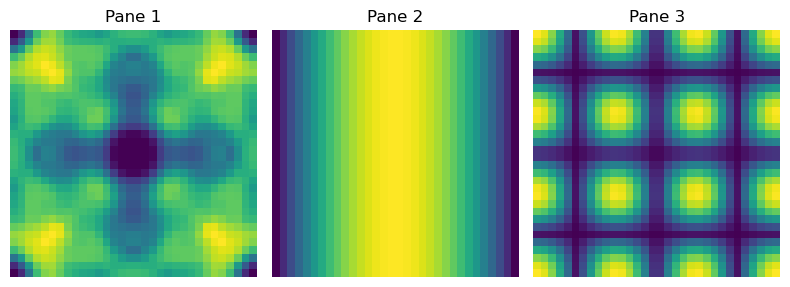

In [20]:
# Visualize a random sample input from the dataset
random_idx = np.random.randint(0, len(dataset))
random_input, random_output = dataset[random_idx]
input_shape = random_input.shape

fig, axes = plt.subplots(1, input_shape[0], figsize=(8, 8))
axes = axes.flatten()

for i in range(3):
    if i == 0:
        img = random_input[i].numpy()
    else:
        img = random_input[i].abs().numpy()
    axes[i].imshow(img, cmap='viridis')
    axes[i].set_title(f'Pane {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

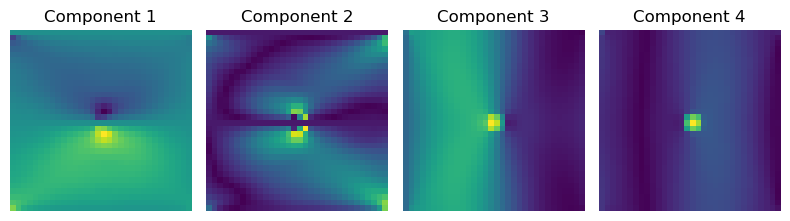

In [21]:
# Visualize a random sample output from the dataset
output_shape = random_output.shape

fig, axes = plt.subplots(1, output_shape[0], figsize=(8, 8))
axes = axes.flatten()

for i in range(4):
    if i % 2 == 0:
        img = random_output[i].numpy()
    else:
        img = random_output[i].abs().numpy()
    axes[i].imshow(img, cmap='viridis')
    axes[i].set_title(f'Component {i+1}')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

In [22]:
# Print the shapes of the input and output data, train, test, and validation sets
print('Input data shape:', input_data.shape)
print('Output data shape:', output_data.shape)
print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

# Inspect the first batch of data
for sample in train_loader:
    print('Batch shape:', sample[0].shape, sample[1].shape)
    #print(sample)
    break

Input data shape: torch.Size([2340000, 3, 32, 32])
Output data shape: torch.Size([2340000, 4, 32, 32])
Train data size: 1755000
Test data size: 468000
Validation data size: 117000
Batch shape: torch.Size([256, 3, 32, 32]) torch.Size([256, 4, 32, 32])


In [23]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels=3, out_channels=4, hidden=32, num_layers=4):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_layers = num_layers

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         n_modes_height=self.modes_height, 
                         n_modes_width=self.modes_width, 
                         hidden_channels=self.hidden, 
                         num_layers=self.num_layers)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [24]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=100, save_after_batch=False, save_path=None):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    progress_bar = tqdm(enumerate(loader), total=total_batches, desc=f"Epoch {epoch + 1}")

    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print progress for each batch
        if (batch_idx + 1) % report_freq == 0 or (batch_idx + 1) == total_batches:
            progress_bar.set_postfix(batch_loss=loss.item())

        # Save model weights after each batch if the flag is set
        if save_after_batch and save_path:
            save_model(model, save_path)

    epoch_loss = running_loss / len(loader.dataset)

    # Save model weights after each epoch if the flag is not set
    if not save_after_batch and save_path:
        save_model(model, save_path)

    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to save the model weights
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

# Function to load the model weights
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [25]:
def plot_sample(data, title, labels, shared_colorbar=False, vmin=None, vmax=None, layout=None, save=False, save_path='plot.png'):
    # Automatically select layout based on the number of data arrays if not provided
    num_arrays = data.shape[0]
    if layout is None:
        if num_arrays == 3:
            layout = (1, 3)
        elif num_arrays == 4:
            layout = (2, 2)
        else:
            raise ValueError("Data input must have 3 or 4 arrays for plotting.")

    # Adjust figure size based on layout
    if layout == (1, 3):
        fig, axes = plt.subplots(*layout, figsize=(12, 4))  # Wide and short for 1x3 layout
    elif layout == (2, 2):
        fig, axes = plt.subplots(*layout, figsize=(8, 8))   # Square for 2x2 layout
    else:
        raise ValueError("Unsupported layout")

    for ax, (idx, label) in zip(axes.flatten(), labels):
        im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
        ax.set_title(label)
        if not shared_colorbar:
            fig.colorbar(im, ax=ax)

    if shared_colorbar:
        # Add a single colorbar to the right of the plot
        cbar = fig.colorbar(im, ax=axes.ravel().tolist())
        cbar.ax.set_ylabel('Color scale')

    plt.suptitle(title)

    if save:
        # Save the figure
        plt.savefig(save_path)
        print(f"Plot saved at {save_path}")
        plt.close(fig)
    else:
        # Display the figure
        plt.show()

def plot_inputs(data, title, labels, save=False, save_path='example_plot.png'):
    # Plot inputs with layout (1, 3) and custom figure size
    plot_sample(data, title, labels, shared_colorbar=True, layout=(1, 3), save=save, save_path=save_path)

def plot_predictions_and_targets(inputs, outputs, targets, save=False, save_dir='figures/', file_suffix='example'):
    # Ensure save directory exists if save is True
    if save:
        os.makedirs(save_dir, exist_ok=True)

    # Add file_suffix to the filenames
    input_filename = f'{save_dir}/input_{file_suffix}.png'
    output_filename = f'{save_dir}/output_{file_suffix}.png'
    target_filename = f'{save_dir}/target_{file_suffix}.png'

    input_labels = [(0, 'geometry'), (1, 'waveform'), (2, 'band')]
    plot_inputs(inputs, 'Inputs', input_labels, save=save, save_path=input_filename)

    # Compute global min and max for shared colorbar between outputs and targets
    vmin = min(np.min(outputs.cpu().numpy()), np.min(targets.cpu().numpy()))
    vmax = max(np.max(outputs.cpu().numpy()), np.max(targets.cpu().numpy()))

    prediction_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(outputs, "Model Predictions", prediction_labels, shared_colorbar=True, vmin=vmin, vmax=vmax, save=save, save_path=output_filename)

    target_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(targets, "Target Values", target_labels, shared_colorbar=True, vmin=vmin, vmax=vmax, save=save, save_path=target_filename)


In [26]:
hc = 256; lr = 1e-3; wd = 0; ss = 10; gamma = 0.1

model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=hc).to(device)

# Define the loss function
criterion = nn.MSELoss()  # Mean Squared Error loss

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ss, gamma=gamma)

In [27]:
# Parameters for saving/loading model weights
save_path = f'./model_weights_hc{hc}_lr{lr:.0e}_wd{wd:.0e}_ss{ss}_gamma{gamma:.0e}.pth'
print(save_path)
load_existing_model = False  # Set to True if you want to load an existing model

# Load the model weights if a valid file path is provided and the flag is set
if load_existing_model and os.path.isfile(save_path):
    load_model(model, save_path)
    print(f"Loaded model weights from {save_path}")

# Lists to store losses for plotting
train_losses = []
val_losses = []

./model_weights_hc256_lr1e-03_wd0e+00_ss10_gamma1e-01.pth


Evaluating: 100%|██████████| 458/458 [00:45<00:00,  9.98it/s]
C:\Users\hz283\AppData\Local\anaconda3\envs\razer\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20, Training Loss: 0.3865, Validation Loss: 0.30449427


Evaluating: 100%|██████████| 458/458 [00:44<00:00, 10.30it/s]


Epoch 2/20, Training Loss: 0.2795, Validation Loss: 0.27162666


Evaluating: 100%|██████████| 458/458 [00:44<00:00, 10.30it/s]


Epoch 3/20, Training Loss: 0.2507, Validation Loss: 0.25335901


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.50it/s]


Epoch 4/20, Training Loss: 0.2331, Validation Loss: 0.24203873


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.58it/s]


Epoch 5/20, Training Loss: 0.2205, Validation Loss: 0.23576691


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.61it/s]


Epoch 6/20, Training Loss: 0.2099, Validation Loss: 0.23081967


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.62it/s]


Epoch 7/20, Training Loss: 0.2003, Validation Loss: 0.22670134


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.59it/s]


Epoch 8/20, Training Loss: 0.1916, Validation Loss: 0.22432464


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.62it/s]


Epoch 9/20, Training Loss: 0.1831, Validation Loss: 0.22396498


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.63it/s]


Epoch 10/20, Training Loss: 0.1748, Validation Loss: 0.22054350


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.62it/s]


Epoch 11/20, Training Loss: 0.1669, Validation Loss: 0.21839247


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.58it/s]


Epoch 12/20, Training Loss: 0.1591, Validation Loss: 0.21878879


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.63it/s]


Epoch 13/20, Training Loss: 0.1519, Validation Loss: 0.21863281


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.62it/s]


Epoch 14/20, Training Loss: 0.1447, Validation Loss: 0.21831722


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.59it/s]


Epoch 15/20, Training Loss: 0.1379, Validation Loss: 0.21613364


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.61it/s]


Epoch 16/20, Training Loss: 0.1312, Validation Loss: 0.21686549


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.65it/s]


Epoch 17/20, Training Loss: 0.1250, Validation Loss: 0.22029685


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.65it/s]


Epoch 18/20, Training Loss: 0.1190, Validation Loss: 0.22265453


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.61it/s]


Epoch 19/20, Training Loss: 0.1135, Validation Loss: 0.22294238


Evaluating: 100%|██████████| 458/458 [00:43<00:00, 10.60it/s]


Epoch 20/20, Training Loss: 0.1082, Validation Loss: 0.22358844


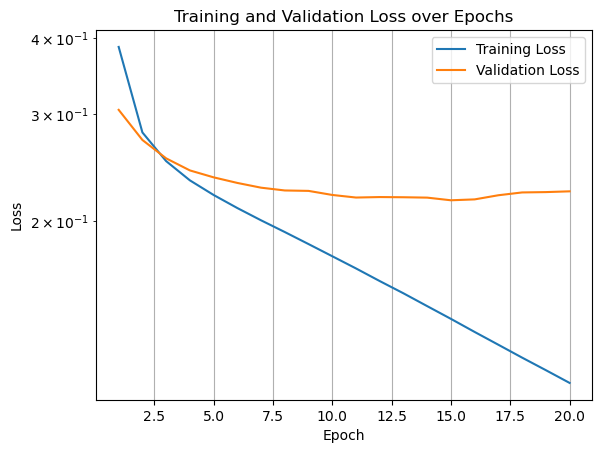

In [28]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=256, save_after_batch=False, save_path=save_path)
    
    val_loss = evaluate(model, val_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

timestamp = datetime.now().strftime('%y%m%d-%H%M%S')
# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Set the y-axis to log scale
plt.savefig(f'loss_plot_{timestamp}.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

In [29]:
# Save the model weights at the end of training
# save_model(model, save_path)
save_path_posttraining = f'{save_path[:-4]}_e{len(train_losses)}.pth'
save_model(model, save_path_posttraining)
print(f"Saved model weights to {save_path_posttraining}")

Saved model weights to ./model_weights_hc256_lr1e-03_wd0e+00_ss10_gamma1e-01_e20.pth


In [30]:
# Load older model weights
# load_path = './model_weights_e101.pth'
# load_model(model, load_path)

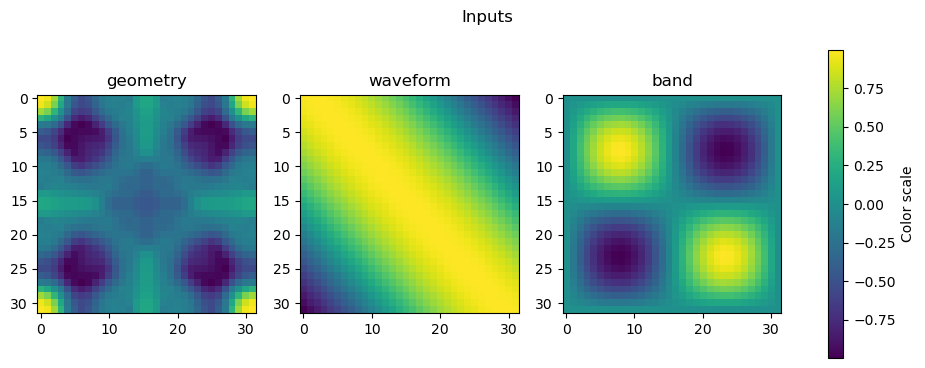

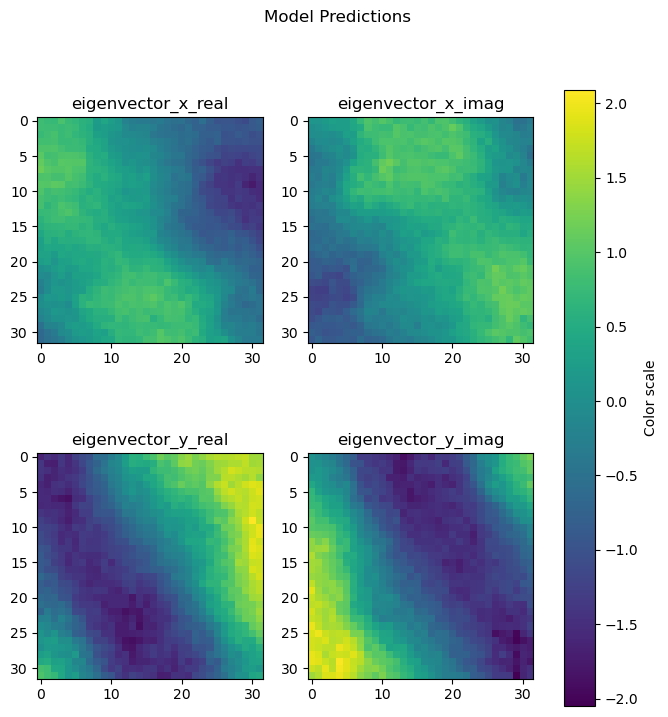

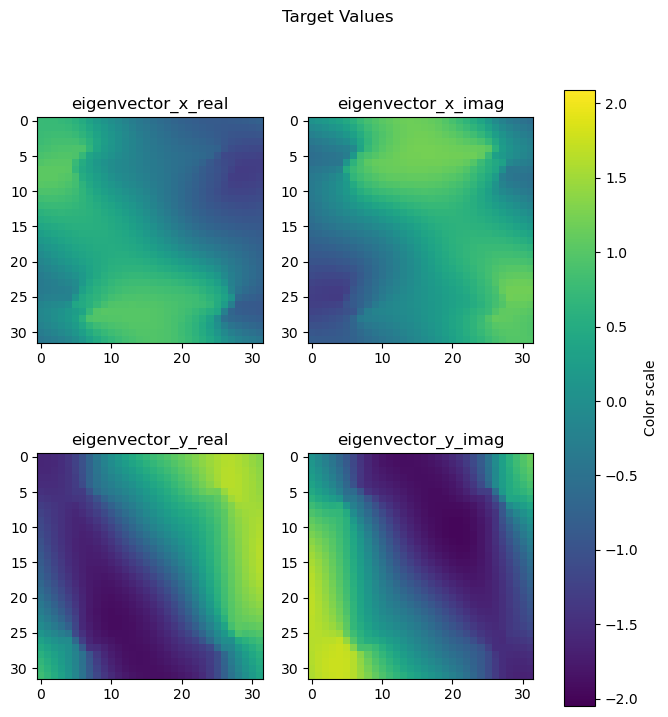

In [39]:
# Get a batch from the validation loader
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get a single sample from the batch
input_sample = inputs[36]
target_sample = targets[36]

# Run the model to get predictions
model.eval()
with torch.no_grad():
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)


In [45]:
def plot_model_weights_histogram(model, log_scale=False, print_analytics=False):
    """
    Plots a histogram of the weight values of a given model.
    
    Parameters:
        model: The model object (e.g., PyTorch or TensorFlow model).
        log_scale (bool): If True, the y-axis of the histogram is set to logarithmic scale.
        print_analytics (bool): If True, prints the mean, standard deviation, and total number of weights.
    """
    # Extract all weight values
    weights = []

    # For PyTorch model
    if hasattr(model, "parameters"):
        for param in model.parameters():
            if param.requires_grad:  # Focus only on trainable parameters
                weights.append(param.data.cpu().numpy().flatten())

    # For TensorFlow/Keras model
    elif hasattr(model, "trainable_weights"):
        for layer_weights in model.trainable_weights:
            weights.append(layer_weights.numpy().flatten())

    else:
        raise ValueError("Unsupported model type. The model must be a PyTorch or TensorFlow model.")

    # Flatten and concatenate all weights into a single array
    all_weights = np.concatenate(weights)

    # Print analytics if the flag is set
    if print_analytics:
        mean = np.mean(all_weights)
        std_dev = np.std(all_weights)
        total_weights = all_weights.size
        print(f"Model Weight Analytics:")
        print(f"  Mean: {mean:.4f}")
        print(f"  Standard Deviation: {std_dev:.4f}")
        print(f"  Total Number of Weights: {total_weights}")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=100, alpha=0.75, color='blue', edgecolor='black')
    plt.title("Histogram of Model Weight Values")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")

    if log_scale:
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.ylabel("Frequency (log scale)")

    plt.grid(axis='y', alpha=0.75)
    plt.show()

Model Weight Analytics:
  Mean: 0.0008
  Standard Deviation: 0.3294
  Total Number of Weights: 285609476


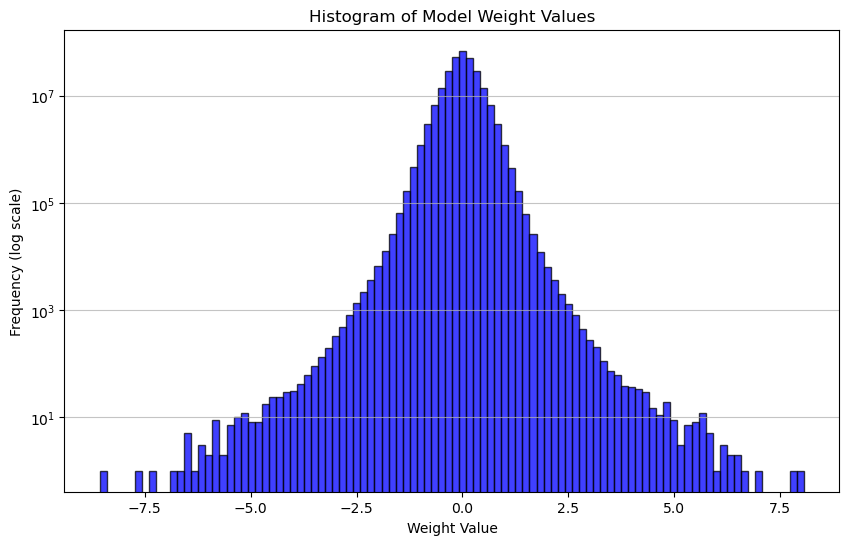

In [46]:
plot_model_weights_histogram(model, log_scale=True, print_analytics=True)

In [47]:
initialized_model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=hc).to(device)

Model Weight Analytics:
  Mean: 0.0000
  Standard Deviation: 0.0442
  Total Number of Weights: 285609476


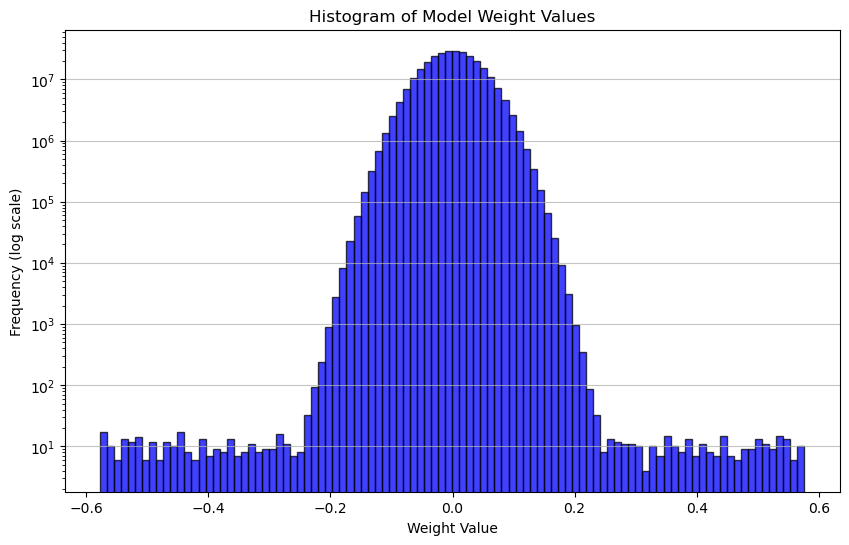

In [50]:
plot_model_weights_histogram(initialized_model, log_scale=True, print_analytics=True)

In [53]:
def process_dataloader(model, dataloader, save_folder, split_name, device='cpu', prefix=""):
    """
    Process a single dataloader, generate predictions, and save predictions, targets, and inputs.

    Parameters:
    - model: Trained PyTorch model.
    - dataloader: DataLoader to process.
    - save_folder: Path to save the output files.
    - split_name: Identifier for the dataset split (e.g., 'train', 'validation', or 'test').
    - device: Device to run the model on ('cpu' or 'cuda').
    - prefix: String to prefix the file names with.
    """
    all_predictions, all_targets, all_inputs = [], [], []

    # Ensure the model is in evaluation mode
    model.eval()
    model.to(device)

    with torch.no_grad():
        for batch in dataloader:
            # Assuming dataloader returns (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Generate predictions
            predictions = model(inputs)

            # Store inputs, targets, and predictions
            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())
            all_inputs.append(inputs.cpu())

    # Concatenate all batches into single tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_inputs = torch.cat(all_inputs, dim=0)

    # Save tensors to files
    os.makedirs(save_folder, exist_ok=True)
    torch.save(all_predictions, os.path.join(save_folder, f"{prefix}{split_name}_predictions.pt"))
    torch.save(all_targets, os.path.join(save_folder, f"{prefix}{split_name}_targets.pt"))
    torch.save(all_inputs, os.path.join(save_folder, f"{prefix}{split_name}_inputs.pt"))

    print(f"Saved {split_name} predictions, targets, and inputs to {save_folder}")


def save_predictions(model, train_loader, val_loader, test_loader, save_folder, device='cpu', prefix="", combine_datasets=False):
    """
    Generate predictions for train, validation, and test datasets, or their combination, and save them to files.

    Parameters:
    - model: Trained PyTorch model.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - test_loader: DataLoader for the test dataset.
    - save_folder: Path to save the output files.
    - device: Device to run the model on ('cpu' or 'cuda').
    - prefix: String to prefix the file names with.
    - combine_datasets (bool): If True, combine all datasets before processing.
    """
    if combine_datasets:
        print("Combining training, validation, and test datasets...")
        combined_dataset = ConcatDataset([
            train_loader.dataset,
            val_loader.dataset,
            test_loader.dataset
        ])
        combined_loader = DataLoader(combined_dataset, batch_size=train_loader.batch_size, shuffle=False)
        process_dataloader(model, combined_loader, save_folder, "combined", device=device, prefix=prefix)
    else:
        # Process train, validation, and test loaders separately
        process_dataloader(model, train_loader, save_folder, "train", device=device, prefix=prefix)
        process_dataloader(model, val_loader, save_folder, "validation", device=device, prefix=prefix)
        process_dataloader(model, test_loader, save_folder, "test", device=device, prefix=prefix)

In [ ]:
save_predictions(model, train_loader, val_loader, test_loader, "prediction target datasets", device='cuda', prefix="hc256_250107_")

In [32]:
def save_sample_predictions(sample_num, interval, filename_suffix, file_path, model, val_loader, device, start_sample=0, plot_preview=False):
    # Ensure the directory exists, create if not
    os.makedirs(file_path, exist_ok=True)

    # Get a batch from the validation loader
    inputs, targets = next(iter(val_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # Loop through the samples based on sample_num
    for i in range(sample_num):
        # Calculate the current sample index based on start_sample and interval
        current_sample = start_sample + i * interval

        # Make sure the current sample index is within bounds
        if current_sample >= len(inputs):
            print(f"Sample index {current_sample} exceeds the number of available samples. Stopping loop.")
            break

        # Extract the current sample for inputs and targets
        input_sample = inputs[current_sample]
        target_sample = targets[current_sample]

        # Run the model to get predictions
        model.eval()
        with torch.no_grad():
            output_sample = model(input_sample.unsqueeze(0)).squeeze(0)

        # Generate the file suffix for this specific sample
        file_suffix = f'sample{i+1}_{filename_suffix}'

        # Plot and save the inputs, predictions, and targets using the new functionality
        plot_predictions_and_targets(
            input_sample,
            output_sample,
            target_sample,
            save=True,                   # Save the plots
            save_dir=file_path,           # Directory to save the plots
            file_suffix=file_suffix       # Suffix to make filenames unique
        )

        # Optionally preview the plots if plot_preview is True
        if plot_preview:
            plot_predictions_and_targets(
                input_sample,
                output_sample,
                target_sample,
                save=False                 # Only display the plots
            )

        print(f'Saved sample {i+1} with suffix {file_suffix} in {file_path}')


In [ ]:
figure_folder = 'figures/hc128'
figure_suffix = f'hc{hc}_lr{lr:.0e}_wd{wd:.0e}_ss{ss}_gamma{gamma:.0e}'
save_sample_predictions(16, 8, figure_suffix, figure_folder, model, val_loader, device)
